In [ ]:
# new transformation from Derek's work
https://github.com/DerekGloudemans/i24-roadway-transforms
1. Create a function that pull off new homography matrics 
2. Create a function that does the transformation from image to relative road

In [1]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA
import glob


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021')
file_name = 'record_p2c2_00001_track_outputs_corrected_3D.csv'
file_path = data_path.joinpath(file_name)
tform_path = data_path.joinpath('i24-roadway-transforms-main/tform')
df = utils.preprocess(file_path, tform_path)
df

Reading data...
Transform from image to road...
Get x direction...
Naive filter...


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:185: RuntimeWarning: invalid value encountered in greater
  outliers = np.logical_or(w1>5, w2>5)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:193: RuntimeWarning: invalid value encountered in greater
  outliers =	abs(l1 - m1) > 2 * s1
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:191: RuntimeWarning: Mean of empty slice
  m1 = np.nanmean(l1)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Deleting unrelavent columns...


,Frame #,Timestamp,ID,Object class,Generation method,fbrx,fbry,fblx,fbly,bbrx,...,btly,fbr_x,fbr_y,fbl_x,fbl_y,bbr_x,bbr_y,bbl_x,bbl_y,direction
0,108,1.758016e+09,261,pickup,Detector,3529.539431,1144.206243,3479.159594,1168.444934,3838.527820,...,1318.599610,300.015589,45.016183,300.827274,42.068023,304.201517,43.415832,304.505876,42.763498,-1.0
1,109,1.758016e+09,261,pickup,Localizer,3478.664101,1092.696317,3416.860180,1127.657884,3791.176890,...,1277.769176,299.153741,45.851079,300.172276,42.299193,303.410860,43.841509,304.082016,43.669232,-1.0
2,110,1.758016e+09,261,pickup,Localizer,3417.016003,1053.309785,3355.583892,1086.754974,3719.647704,...,1229.421605,298.274734,46.124197,299.291922,42.570887,302.571279,44.110637,303.237244,43.953659,-1.0
3,111,1.758016e+09,261,pickup,Localizer,3356.939887,1015.686896,3295.018662,1047.735830,3646.681602,...,1181.327845,297.370444,46.374027,298.400224,42.812838,301.680742,44.331148,302.333262,44.198714,-1.0
4,112,1.758016e+09,261,pickup,Localizer,3277.357120,983.940774,3237.911276,1008.964082,3576.341136,...,1149.188601,296.487324,46.076224,297.149567,43.117410,300.803918,44.581852,301.429216,44.505978,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9407,1810,1.758016e+09,312261,semi,Localizer,2260.056262,2170.186094,2423.867082,2050.030588,1335.071036,...,832.374904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9408,1811,1.758016e+09,312261,semi,Localizer,2318.168792,2235.316042,2478.606114,2115.106712,1364.896994,...,867.060076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9409,1812,1.758016e+09,312261,semi,Detector,2363.585940,2292.119972,2546.801016,2152.394086,1395.825942,...,902.209342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9410,1813,1.758016e+09,312261,semi,Localizer,2367.018736,2295.758068,2547.066936,2158.281432,1428.216760,...,938.490398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [3]:
# apply new transformation to the old video image
import cv2
camera_id = 'p2c3'
vidcap = cv2.VideoCapture('../2D-3D May 2021/record_p2c3_00001_track_outputs_corrected_3D.csv_3D.mp4')
success,image = vidcap.read()
count = 0
while success:
    count += 1
    if count <=1:
        cv2.imwrite(camera_id+"frame_1.jpg" % count, image)     # save frame as JPEG file      
        success,image = vidcap.read()
        print('Read a new frame: ', success)  
    else:
        break

Read a new frame:  True


Original Dimensions :  (2160, 3840, 3)
Resized Dimensions :  (1080, 1920, 3)


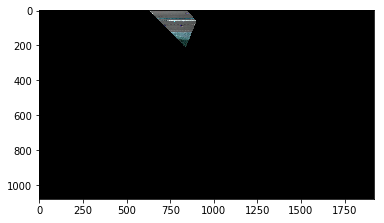

In [16]:
M = utils.get_homography_matrix('p2c2',tform_path)
# Read source image.
im_src = cv2.imread('p2c2_frame1.jpg')
print('Original Dimensions : ',im_src.shape)
scale = 0.5 # percent of original size
width = int(im_src.shape[1] * scale)
height = int(im_src.shape[0] * scale)
dim = (width, height)
  
# resize image
resized = cv2.resize(im_src, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
 
# cv2.imshow("Resized image", resized)
%matplotlib inline
im_out = cv2.warpPerspective(resized, M, dim)
plt.imshow(im_out)
# cv2.waitKey(0)

In [18]:
invM = np.linalg.inv(M)
np.linalg.cond(M)

1001714.0384200751

In [29]:
# try validate the points using M
import glob
tf_file = glob.glob(str(tform_path) + '/' + camera_id + "*.csv")[0]
tf = pd.read_csv(tf_file)
img_pts = np.array(tf.iloc[:-4,0:2], dtype=float)
road_pts_true = np.array(tf.iloc[:-4,2:4], dtype=float)

In [30]:
img_pts_1 = np.vstack((np.transpose(img_pts), np.ones((1,len(img_pts))))) # add ones to standardize
road_pts_un = M.dot(img_pts_1) # convert to gps unnormalized
road_pts_1 = road_pts_un / road_pts_un[-1,:][np.newaxis, :] # gps normalized s.t. last row is 1
road_pts = np.transpose(road_pts_1[0:2,:]) # only use the first two rows, convert from ft to m
road_pts - road_pts_true

array([[ 0.19706429, -0.33202042],
       [ 0.23856139, -0.31863427],
       [-0.49524102, -0.27961998],
       [ 0.29085719, -0.26524121],
       [-0.22260777, -0.22593319],
       [ 0.56930849, -0.21154666],
       [-0.79671983, -0.17337518],
       [ 0.21857271, -0.15869087],
       [ 0.18091793,  0.10498747],
       [-0.01266362,  0.10463642],
       [-0.11969405,  0.10356628],
       [ 0.10312848,  0.10320032],
       [-0.17292308,  0.10213624],
       [ 0.27300143,  0.10176228],
       [-0.31828831,  0.10070949],
       [ 0.0654797 ,  0.10033776],
       [ 0.16514582,  0.25372745],
       [-0.25835949,  0.25448719],
       [ 0.24888236,  0.25690743],
       [-0.08135263,  0.25767456],
       [-0.12392414,  0.26005118],
       [-0.01959453,  0.26085279],
       [ 0.1557952 ,  0.26324671],
       [-0.08642261,  0.26402082],
       [ 0.14951208,  0.29588973],
       [-0.50152177,  0.27905004],
       [ 0.61178029,  0.22300765],
       [-0.26271346,  0.20657046],
       [-0.07599631,

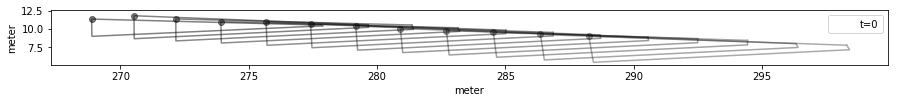

In [28]:
import utils
importlib.reload(utils)
Y = df[df['ID']==261]
D = np.array(Y[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(D)

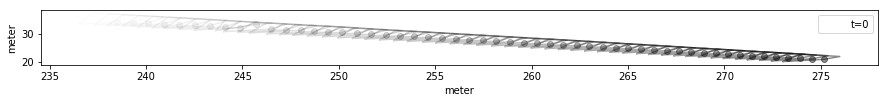

In [33]:
import utils
importlib.reload(utils)
Y = df[df['ID']==22261]
D = np.array(Y[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(D)